# Redes neurais Recorrentes (RNN)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Bibliotecas básicas

In [2]:
import re
import os
import io
import time
import string
import numpy as np
import pandas as pd
from string import digits
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

2.4.1


## Tradução automática neural com mecanismo de atenção

#### Carrega os dados

In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/spa-eng/spa.txt'
lines_raw = pd.read_table(data_path, names = ['source', 'target', 'comments'])
lines_raw.sample(5)

,source,target,comments
54051,Let me just go talk to Tom.,Solo déjame ir a hablar con Tom.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
93875,There's a pub just around the corner.,Hay un pub al torcer la esquina.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
91102,Tom bought a camera to give to Mary.,Tom compró una cámara para regalársela a Mary.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
56216,You must perform your duty.,Debes cumplir con tu deber.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
22197,I don't like movies.,No me gusta ver películas.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [4]:
print(f'Linha: {lines_raw.shape[0]} | Coluna: {lines_raw.shape[1]}')

Linha: 128084 | Coluna: 3


In [5]:
lines_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128084 entries, 0 to 128083
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   source    128084 non-null  object
 1   target    128084 non-null  object
 2   comments  128084 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


#### Pré-processa as frases fonte e alvo para ter pares de palavras no formato: [INGLÊS, ESPANHOL]

In [6]:
def preprocess_sentence(sentence):
    num_digits= str.maketrans('', '', digits)    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'    
    return sentence

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

sample_size=60000
source, target, _ = create_dataset(data_path, sample_size)

#### Tokeniza e converte o texto em uma sequência de inteiros

In [7]:
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post')

target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )

#### Separação treino e teste

In [8]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor = train_test_split(source_tensor, 
                                                                                                    target_tensor, 
                                                                                                    test_size=0.2)

#### Cria dados na memoria

In [9]:
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BATCH_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
source_batch, target_batch = next(iter(dataset))
print(source_batch.shape)
print(target_batch.shape)

(64, 13)
(64, 20)


#### Cria o modelo

In [10]:
BUFFER_SIZE = len(source_train_tensor)
steps_per_epoch= len(source_train_tensor)//BATCH_SIZE
embedding_dim=256
units=1024
source_vocab_size= len(source_sentence_tokenizer.word_index)+1
target_vocab_size= len(target_sentence_tokenizer.word_index)+1

Encoder

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size= batch_size
        self.encoder_units=encoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru= tf.keras.layers.GRU(encoder_units,return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [12]:
encoder = Encoder(source_vocab_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden= encoder(source_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 13, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


Camada de atenção

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score= self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))    
        attention_weights= tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [14]:
attention_layer= BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print('Attention result shape: (batch size, units) {}'.format(attention_result.shape))
print('Attention weights shape: (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 13, 1)


Decoder

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [16]:
decoder = Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15349)


Otimizador e função de perda

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

Checkpoint

In [18]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

#### Treina o modelo

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [20]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
  
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 3.0799362659454346
Epoch 1 Batch 100 loss 1.5914896726608276
Epoch 1 Batch 200 loss 1.4999147653579712
Epoch 1 Batch 300 loss 1.3425962924957275
Epoch 1 Batch 400 loss 1.268446922302246
Epoch 1 Batch 500 loss 1.1572431325912476
Epoch 1 Batch 600 loss 1.0980063676834106
Epoch 1 Batch 700 loss 1.0921634435653687
Epoch 1 Loss 1.3365
Time taken for 1 epoch 4904.994888782501 sec

Epoch 2 Batch 0 loss 0.9378819465637207
Epoch 2 Batch 100 loss 0.960283100605011
Epoch 2 Batch 200 loss 0.8661623001098633
Epoch 2 Batch 300 loss 0.9111055731773376
Epoch 2 Batch 400 loss 0.7920030355453491
Epoch 2 Batch 500 loss 0.7733731269836426
Epoch 2 Batch 600 loss 0.7268795967102051
Epoch 2 Batch 700 loss 0.6980582475662231
Epoch 2 Loss 0.8219
Time taken for 1 epoch 4849.427884340286 sec

Epoch 3 Batch 0 loss 0.6220558881759644
Epoch 3 Batch 100 loss 0.5717284679412842
Epoch 3 Batch 200 loss 0.5847135782241821
Epoch 3 Batch 300 loss 0.5980767011642456
Epoch 3 Batch 400 loss 0.53354877233

#### Tradução

In [26]:
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

def evaluate(sentence):
    attention_plot = np.zeros((max_target_length, max_source_length))

    sentence = preprocess_sentence(sentence)
    inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_source_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

    for t in range(max_target_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
        return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

#### Plota os pesos

In [38]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)  
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

#### Restaura o último ponto de verificação e testa

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Traduções finais com gráficos de atenção

Input: start_ i am going to work . _end
Predicted translation: . 


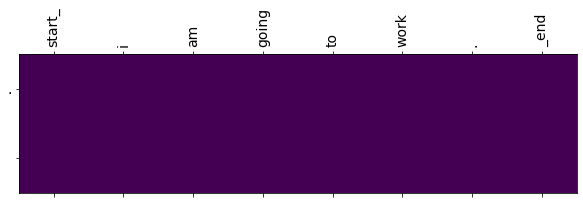

In [39]:
translate(u'I am going to work.')